In [1]:
import os
import json
import time
import hashlib
import re
from collections import Counter
from typing import Optional, Dict, Any, List

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "yelp.csv"        # must contain 'text' and 'stars' columns
SAMPLE_SIZE = 2000            # target sample size to evaluate (set as high as you want)
SEED_SIZE = 1000              # labeled seed used to train triage classifier
TRIAGE_MAX_FEATURES = 20000
TRIAGE_NGRAM = (1,2)
THRESH = 0.75                 # confidence threshold: rows with prob < THRESH go to LLM
N_VOTES_ON_FAILURE = 3        # if initial LLM parse fails, do up to this many calls (including first)
TEMPERATURE = 0.0             # default for evaluation
CACHE_DIR = "llm_cache"       # persistent cache for LLM outputs
MAX_LLM_CALLS = None          # set to int to cap LLM calls, else None

# LLM model config (adjust for your provider)
LLM_MODEL = "llama-3.3-70b-versatile"  # if using groq
GROQ_API_KEY = os.getenv("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", None)

In [7]:
df_full = pd.read_csv(DATA_PATH)
assert "text" in df_full.columns and "stars" in df_full.columns, "CSV must have 'text' and 'stars' columns"

df_full = df_full[["text", "stars"]].dropna().reset_index(drop=True)
if SAMPLE_SIZE >= len(df_full):
    df_sample = df_full.copy()
else:
    df_sample = df_full.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print(f"Dataset total: {len(df_full)}, Evaluation sample: {len(df_sample)}")
df_sample.head()

Dataset total: 10000, Evaluation sample: 2000


,text,stars
0,We got here around midnight last Friday... the...,4
1,Brought a friend from Louisiana here. She say...,5
2,"Every friday, my dad and I eat here. We order ...",3
3,"My husband and I were really, really disappoin...",1
4,Love this place! Was in phoenix 3 weeks for w...,5


In [9]:
try:
    from groq import Groq
    client = Groq(GROQ_API_KEY) if GROQ_API_KEY else None
except Exception:
    client = None

def call_llm(prompt: str, temperature: float = TEMPERATURE) -> str:
    """
    Replace/modify this function if you use a different LLM provider.
    Must return model text output (string).
    """
    if client is None:
        raise RuntimeError("LLM client not configured. Set GROQ_API_KEY or modify call_llm.")
    completion = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature
    )
    return completion.choices[0].message.content

In [11]:
def prompt_strict_schema(review: str) -> str:
    return f"""You are a classifier. Given the Yelp review below, return ONLY valid JSON and NOTHING else.
The JSON must conform exactly to this schema:
{{"predicted_stars": integer between 1 and 5 inclusive, "explanation": string (brief)}}

Review:
\"\"\"{review}\"\"\"

Return only one JSON object on the first line. Example: {{"predicted_stars": 4, "explanation": "reason"}}
"""

def prompt_few_shot_edgecases(review: str) -> str:
    examples = [
        ('"Terrible service, food was cold."', 1, "Very negative experience"),
        ('"Great value and friendly staff."', 5, "Positive experience"),
        ('"Okay food, long wait but decent."', 3, "Mixed/neutral review"),
        ('"Not bad, but will not return."', 2, "Slightly negative"),
        ('"Loved the ambiance. Food average."', 4, "Mostly positive with caveats"),
    ]
    ex_text = "\n".join(
        f'Review: {ex[0]}  ->  {{"predicted_stars": {ex[1]}, "explanation": "{ex[2]}"}}'
        for ex in examples
    )
    return f"""
You will read a review and output ONLY a single JSON object with keys:
- predicted_stars: integer 1-5
- explanation: brief reason (1-2 sentences)

Examples:
{ex_text}

Now rate this review:
Review: \"\"\"{review}\"\"\"

Output valid JSON only.
"""

def prompt_cot_then_json(review: str) -> str:
    return f"""
Please analyze the review in 2 quick steps (internally) then output ONLY the final JSON below.
1) Identify sentiment (positive, negative, neutral).
2) Identify the strongest signal (service, food, value, ambiance).
Do NOT print the steps — print ONLY the final JSON.

Review:
\"\"\"{review}\"\"\"

Return ONLY:
{{"predicted_stars": integer (1-5), "explanation": "one-line reason"}}
"""

PROMPTS = {
    "Strict-Schema": prompt_strict_schema,
    "Few-Shot-Edgecases": prompt_few_shot_edgecases,
    "CoT-FinalJSON": prompt_cot_then_json
}

In [13]:
JSON_RE = re.compile(r'(\{.*\})', re.DOTALL)

def parse_json_safe(text: str) -> Optional[Dict[str, Any]]:
    if not isinstance(text, str):
        return None
    # try direct parse
    try:
        j = json.loads(text.strip())
    except Exception:
        m = JSON_RE.search(text)
        if not m:
            return None
        candidate = m.group(1)
        try:
            j = json.loads(candidate)
        except Exception:
            candidate2 = candidate.replace(",}", "}").replace(",]", "]")
            try:
                j = json.loads(candidate2)
            except Exception:
                return None
    if not isinstance(j, dict):
        return None
    if "predicted_stars" not in j or "explanation" not in j:
        return None
    # coerce predicted_stars
    ps = j["predicted_stars"]
    try:
        ps_int = int(ps)
    except Exception:
        try:
            ps_int = int(float(ps))
        except Exception:
            return None
    if not (1 <= ps_int <= 5):
        return None
    exp = j["explanation"]
    if not isinstance(exp, str):
        exp = str(exp)
    return {"predicted_stars": ps_int, "explanation": exp.strip()}


In [15]:
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_META = os.path.join(CACHE_DIR, "cache_index.json")
if os.path.exists(CACHE_META):
    try:
        with open(CACHE_META, "r", encoding="utf-8") as f:
            cache_index = json.load(f)
    except Exception:
        cache_index = {}
else:
    cache_index = {}

def review_hash(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()

def cache_get(review_text: str, prompt_name: str) -> Optional[Dict[str, Any]]:
    key = review_hash(prompt_name + "|" + review_text)
    if key in cache_index:
        file_path = cache_index[key]["file"]
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return None
    return None

def cache_set(review_text: str, prompt_name: str, raw_outputs: List[str], parsed_votes: List[Any]) -> None:
    key = review_hash(prompt_name + "|" + review_text)
    file_name = f"{key}.json"
    file_path = os.path.join(CACHE_DIR, file_name)
    payload = {"prompt_name": prompt_name, "review": review_text, "raw_outputs": raw_outputs, "parsed_votes": parsed_votes}
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False)
    cache_index[key] = {"file": file_path}
    with open(CACHE_META, "w", encoding="utf-8") as f:
        json.dump(cache_index, f, ensure_ascii=False)


In [17]:
def train_triage(df_train: pd.DataFrame):
    vect = TfidfVectorizer(max_features=TRIAGE_MAX_FEATURES, ngram_range=TRIAGE_NGRAM)
    X = vect.fit_transform(df_train["text"].astype(str).tolist())
    y = df_train["stars"].astype(int).tolist()
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    return vect, clf

# Train triage classifier on SEED_SIZE (use labels we have)
seed = df_full.sample(SEED_SIZE, random_state=123).reset_index(drop=True)
vect, clf = train_triage(seed)
print("Triage classifier trained.")


Triage classifier trained.


In [19]:
llm_call_count = 0

def process_review_with_triage_and_llm(review_text: str, prompt_fn, n_votes_on_failure: int = N_VOTES_ON_FAILURE):
    """
    Returns parsed result dict or None.
    Uses caching, triage is already applied upstream (this function only handles LLM).
    Implements retries and adaptive voting.
    """
    global llm_call_count
    # check cache
    cached = cache_get(review_text, prompt_fn.__name__)
    if cached:
        # return majority parsed_vote if present else None
        parsed_votes = cached.get("parsed_votes", [])
        if parsed_votes:
            return {"predicted_stars": Counter(parsed_votes).most_common(1)[0][0],
                    "explanation": parsed_votes[0] if parsed_votes else ""}
        return None

    raw_outputs = []
    parsed_votes = []

    # First attempt single call
    if MAX_LLM_CALLS is not None and llm_call_count >= MAX_LLM_CALLS:
        return None

    try:
        raw = call_llm(prompt_fn(review_text), temperature=TEMPERATURE)
    except Exception as e:
        raw = ""
    llm_call_count += 1
    raw_outputs.append(raw)
    p = parse_json_safe(raw)
    if p:
        parsed_votes.append(p["predicted_stars"])
    else:
        # Retry up to n_votes_on_failure - 1 times if parsing fails
        for attempt in range(n_votes_on_failure - 1):
            if MAX_LLM_CALLS is not None and llm_call_count >= MAX_LLM_CALLS:
                break
            try:
                raw = call_llm(prompt_fn(review_text), temperature=TEMPERATURE)
            except Exception:
                raw = ""
            llm_call_count += 1
            raw_outputs.append(raw)
            p2 = parse_json_safe(raw)
            if p2:
                parsed_votes.append(p2["predicted_stars"])
                break
            time.sleep(0.1)  # tiny backoff

    # Save to cache (even if parsed_votes empty)
    cache_set(review_text, prompt_fn.__name__, raw_outputs, parsed_votes)
    if parsed_votes:
        return {"predicted_stars": Counter(parsed_votes).most_common(1)[0][0],
                "explanation": ""}  # explanation captured if desired by parsing first valid output
    return None


In [21]:
X_sample = vect.transform(df_sample["text"].astype(str).tolist())
probs = clf.predict_proba(X_sample)  # shape (n, n_classes)
preds_triage = clf.predict(X_sample)
confidences = probs.max(axis=1)

# Decide which rows to escalate
low_conf_idxs = np.where(confidences < THRESH)[0]
print(f"Rows below threshold (need LLM triage): {len(low_conf_idxs)} / {len(df_sample)}")

# We'll evaluate each prompt strategy on the same triaged subset (so LLM calls comparable)
results = {}
for prompt_name, prompt_fn in PROMPTS.items():
    print(f"\n--- Running strategy: {prompt_name} ---")
    outputs = []
    llm_call_count_before = llm_call_count
    # For each row in sample, either accept triage prediction or call LLM (if low confidence)
    for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        i_idx = int(i)
        review = row["text"]
        true_star = int(row["stars"])
        if i_idx not in low_conf_idxs:
            # accept triage predicted label
            outputs.append({
                "index": i_idx,
                "method": "triage",
                "predicted": int(preds_triage[i_idx]),
                "conf": float(confidences[i_idx]),
                "true": true_star,
                "parsed_votes": None
            })
        else:
            # call LLM (with caching + retries)
            res = process_review_with_triage_and_llm(review, prompt_fn, n_votes_on_failure=N_VOTES_ON_FAILURE)
            if res:
                outputs.append({
                    "index": i_idx,
                    "method": "llm",
                    "predicted": int(res["predicted_stars"]),
                    "conf": float(confidences[i_idx]),
                    "true": true_star,
                    "parsed_votes": None
                })
            else:
                # fallback to triage prediction if LLM fails/parse fails
                outputs.append({
                    "index": i_idx,
                    "method": "fallback",
                    "predicted": int(preds_triage[i_idx]),
                    "conf": float(confidences[i_idx]),
                    "true": true_star,
                    "parsed_votes": None
                })

    llm_calls_used = llm_call_count - llm_call_count_before
    print(f"LLM calls used for strategy '{prompt_name}': {llm_calls_used}")
    # compute metrics: accuracy, rate LLM used, etc
    df_out = pd.DataFrame(outputs)
    accuracy = (df_out["predicted"] == df_out["true"]).mean()
    llm_rate = (df_out["method"] == "llm").mean()
    fallback_rate = (df_out["method"] == "fallback").mean()
    triage_rate = (df_out["method"] == "triage").mean()
    results[prompt_name] = {
        "accuracy": accuracy,
        "llm_rate": llm_rate,
        "triage_rate": triage_rate,
        "fallback_rate": fallback_rate,
        "llm_calls": llm_calls_used,
        "df_out": df_out
    }

Rows below threshold (need LLM triage): 1999 / 2000

--- Running strategy: Strict-Schema ---


100%|██████████| 2000/2000 [07:49<00:00,  4.26it/s]


LLM calls used for strategy 'Strict-Schema': 5997

--- Running strategy: Few-Shot-Edgecases ---


100%|██████████| 2000/2000 [09:05<00:00,  3.67it/s]


LLM calls used for strategy 'Few-Shot-Edgecases': 5997

--- Running strategy: CoT-FinalJSON ---


100%|██████████| 2000/2000 [10:07<00:00,  3.29it/s]

LLM calls used for strategy 'CoT-FinalJSON': 5997


In [45]:
# --- Cell A: Build comparison table and show sample outputs per prompt ---

rows = []

for name, r in results.items():

    # Safely get df_out
    df_out = r.get("df_out", None)
    if df_out is None or not isinstance(df_out, pd.DataFrame):
        df_out = r.get("df", None)

    # Compute JSON validity rate safely
    if isinstance(df_out, pd.DataFrame):
        total = len(df_out)
        json_valid_count = df_out["method"].str.contains("llm", case=False, na=False).sum()
        json_valid_rate = json_valid_count / total if total > 0 else 0.0
    else:
        total = 0
        json_valid_rate = 0.0

    rows.append({
        "Prompt Type": name,
        "Accuracy": float(r.get("accuracy", 0.0)),
        "JSON Validity Rate": float(json_valid_rate),
        "LLM usage rate": float(r.get("llm_rate", 0.0)),
        "Triage accepted rate": float(r.get("triage_rate", 0.0)),
        "Fallback rate": float(r.get("fallback_rate", 0.0)),
        "LLM_calls": int(r.get("llm_calls", 0)),
    })

df_compare = pd.DataFrame(rows)
display(df_compare)

# Show sample rows per prompt for debugging
for name, r in results.items():
    df_out = r.get("df_out", None)
    if df_out is None or not isinstance(df_out, pd.DataFrame):
        df_out = r.get("df", None)

    print(f"\n--- Sample rows for prompt: {name} ---")
    if isinstance(df_out, pd.DataFrame):
        display(df_out.head(10))
    else:
        print("No df_out or df available.")


,Prompt Type,Accuracy,JSON Validity Rate,LLM usage rate,Triage accepted rate,Fallback rate,LLM_calls
0,Strict-Schema,0.481,0.0,0.0,0.0005,0.9995,5997
1,Few-Shot-Edgecases,0.481,0.0,0.0,0.0005,0.9995,5997
2,CoT-FinalJSON,0.481,0.0,0.0,0.0005,0.9995,5997



--- Sample rows for prompt: Strict-Schema ---


,index,method,predicted,conf,true,parsed_votes
0,0,fallback,4,0.443977,4,None
1,1,fallback,5,0.612602,5,None
2,2,fallback,4,0.383702,3,None
3,3,fallback,4,0.349527,1,None
4,4,fallback,5,0.510419,5,None
5,5,fallback,4,0.451149,4,None
6,6,fallback,5,0.364028,4,None
7,7,fallback,5,0.439924,4,None
8,8,fallback,4,0.448483,5,None
9,9,fallback,1,0.269093,1,None



--- Sample rows for prompt: Few-Shot-Edgecases ---


,index,method,predicted,conf,true,parsed_votes
0,0,fallback,4,0.443977,4,None
1,1,fallback,5,0.612602,5,None
2,2,fallback,4,0.383702,3,None
3,3,fallback,4,0.349527,1,None
4,4,fallback,5,0.510419,5,None
5,5,fallback,4,0.451149,4,None
6,6,fallback,5,0.364028,4,None
7,7,fallback,5,0.439924,4,None
8,8,fallback,4,0.448483,5,None
9,9,fallback,1,0.269093,1,None



--- Sample rows for prompt: CoT-FinalJSON ---


,index,method,predicted,conf,true,parsed_votes
0,0,fallback,4,0.443977,4,None
1,1,fallback,5,0.612602,5,None
2,2,fallback,4,0.383702,3,None
3,3,fallback,4,0.349527,1,None
4,4,fallback,5,0.510419,5,None
5,5,fallback,4,0.451149,4,None
6,6,fallback,5,0.364028,4,None
7,7,fallback,5,0.439924,4,None
8,8,fallback,4,0.448483,5,None
9,9,fallback,1,0.269093,1,None


Saved confusion matrix CSV: confusion_matrix_Strict-Schema.csv  (rows used: 2000)


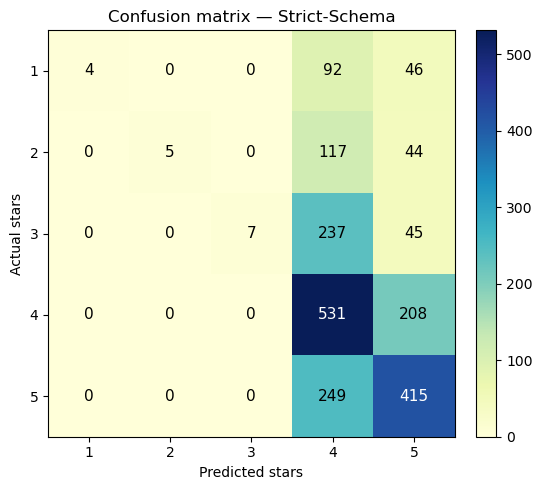

Saved confusion matrix CSV: confusion_matrix_Few-Shot-Edgecases.csv  (rows used: 2000)


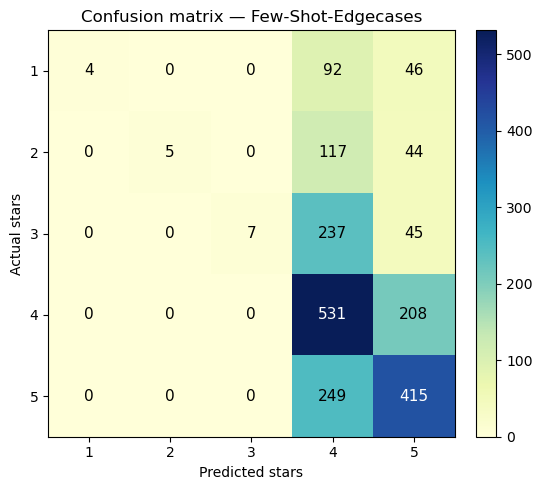

Saved confusion matrix CSV: confusion_matrix_CoT-FinalJSON.csv  (rows used: 2000)


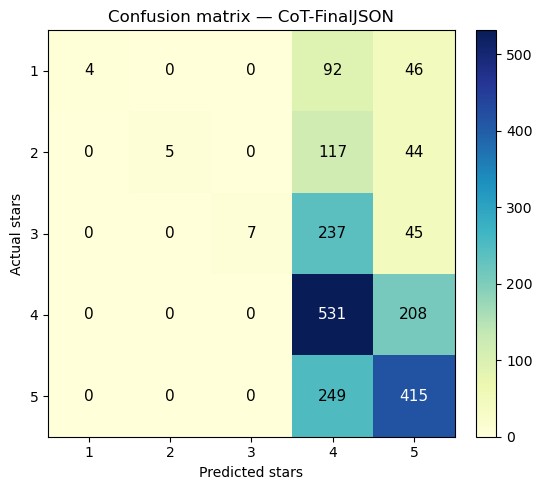

In [65]:
# Confusion heatmaps (Actual vs Predicted) WITHOUT examples; saves CSV per prompt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def safe_get_df(r):
    df_out = r.get("df_out", None)
    if df_out is None or not isinstance(df_out, pd.DataFrame):
        df_out = r.get("df", None)
    return df_out

def find_pred_col(df):
    for c in ("predicted_stars","predicted","pred","predicted_star"):
        if c in df.columns:
            return c
    # fallback: numeric column not 'true'/'stars'
    for c in df.columns:
        if c in ("true","stars","method","text","explanation"): 
            continue
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

def find_true_col(df):
    for c in ("true","stars","label","actual"):
        if c in df.columns:
            return c
    return None

for name, r in results.items():
    df_out = safe_get_df(r)
    if df_out is None or len(df_out) == 0:
        print(f"\nSkipping prompt '{name}': no dataframe available.")
        continue

    pred_col = find_pred_col(df_out)
    true_col = find_true_col(df_out)
    if pred_col is None or true_col is None:
        print(f"\nSkipping prompt '{name}': couldn't find pred/true columns (pred={pred_col}, true={true_col}).")
        continue

    # Copy and coerce to int where possible
    df_local = df_out[[pred_col, true_col]].dropna().copy()
    try:
        df_local[true_col] = df_local[true_col].astype(int)
        df_local[pred_col] = df_local[pred_col].astype(int)
    except Exception:
        df_local[true_col] = df_local[true_col].apply(lambda x: int(float(x)) if pd.notna(x) else x)
        df_local[pred_col] = df_local[pred_col].apply(lambda x: int(float(x)) if pd.notna(x) else x)

    # Keep only 1..5 range
    df_local = df_local[df_local[true_col].between(1,5) & df_local[pred_col].between(1,5)]

    # Build 5x5 matrix (rows: actual 1..5, cols: predicted 1..5)
    n = 5
    mat = np.zeros((n, n), dtype=int)
    for _, row in df_local.iterrows():
        a = int(row[true_col])
        p = int(row[pred_col])
        mat[a-1, p-1] += 1

    # Save matrix to CSV
    mat_df = pd.DataFrame(mat, index=[f"Actual_{i}" for i in range(1,6)],
                          columns=[f"Pred_{i}" for i in range(1,6)])
    csv_name = f"confusion_matrix_{name}.csv"
    mat_df.to_csv(csv_name, index=True)
    print(f"Saved confusion matrix CSV: {csv_name}  (rows used: {len(df_local)})")

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(mat, cmap="YlGnBu", vmin=0)
    ax.set_xticks(np.arange(n)); ax.set_yticks(np.arange(n))
    ax.set_xticklabels(range(1,6)); ax.set_yticklabels(range(1,6))
    ax.set_xlabel("Predicted stars"); ax.set_ylabel("Actual stars")
    ax.set_title(f"Confusion matrix — {name}")

    # Annotate counts in cells
    max_val = mat.max() if mat.size else 0
    for i in range(n):
        for j in range(n):
            count = mat[i, j]
            color = "white" if count > (max_val/2 if max_val>0 else 0) else "black"
            ax.text(j, i, str(count), ha="center", va="center", color=color, fontsize=11)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [69]:
# Save outputs to CSV for inspection
for name, r in results.items():
    r["df_out"].to_csv(f"eval_{name}.csv", index=False)
    print(f"Saved eval_{name}.csv (rows={len(r['df_out'])})")

# Save cache index
with open(os.path.join(CACHE_DIR, "cache_index.json"), "w", encoding="utf-8") as f:
    json.dump(cache_index, f, ensure_ascii=False, indent=2)

print("Done. Tune THRESH, SEED_SIZE, N_VOTES_ON_FAILURE, and SAMPLE_SIZE for desired cost/accuracy trade-off.")


Saved eval_Strict-Schema.csv (rows=2000)
Saved eval_Few-Shot-Edgecases.csv (rows=2000)
Saved eval_CoT-FinalJSON.csv (rows=2000)
Done. Tune THRESH, SEED_SIZE, N_VOTES_ON_FAILURE, and SAMPLE_SIZE for desired cost/accuracy trade-off.
